In [1]:
import torch
from torch import nn
import torchvision
import os
import matplotlib.pyplot as plt
import numpy as np
from resnet import ResNet, ResNetEnsembleInfraredRGB
from dataloaders import  load_sheep_grid_data, load_sheep_grid_multiband
from utils import to_cuda
from loss_functions import MultiLabelSoftMarginLossIgnoreEdgeCases
#from utils import show_im_with_grid_labels
import time

In [2]:
from scipy.optimize import fsolve
import math

math.log(math.sqrt(5)-1) -math.log(2)


-0.48121182505960336

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

In [4]:
torch.cuda.empty_cache()

img_type = 'infrared'
time_stamp = '20200221_1432' #     20200218_1121 20200218_1929

img_type='rgb'
time_stamp = '20200229_2120' #  20200217_0108 20200218_1115 20200218_1940

#img_type='ensemble'
#time_stamp = '20200224_0830' #   

batch_size = 50
rgb_size = 1280

infrared_size = 160
include_msx = False
test_dataset = 'not train'
show_ims = False
calculate_loss = False


root_work_dir = './Work_dirs/work_dirs_external/'
work_dir = root_work_dir+ img_type +'/' + time_stamp



## IF ENSEMBLE ###
time_stamp_rgb = '20200222_0826'
time_stamp_infrared = '20200221_1432'


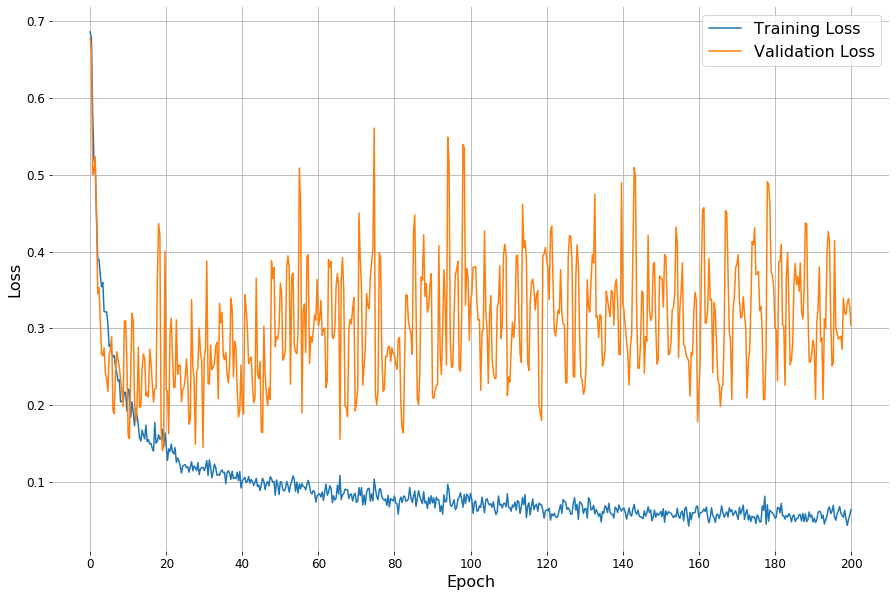

In [5]:
import math
with open( os.path.join(work_dir, 'TRAIN_LOSS.txt' ), 'r') as f:
    train_loss = list(map(float,  f.readlines()[0].split() )) 
    
with open( os.path.join(work_dir, 'VALIDATION_LOSS.txt' ), 'r') as f:
    validation_loss =list(map(float,  f.readlines()[0].split() )) 
    
log_per_epoch = 3

epochs = math.ceil(len(train_loss)/log_per_epoch)
x = np.arange(0, epochs + 1/log_per_epoch , 1/log_per_epoch)[0:len(train_loss)]


fig, ax = plt.subplots(figsize=(15,10))

ax.plot(x, train_loss, label='Training Loss')
ax.plot(x, validation_loss, label='Validation Loss')
#plt.ylim((0.1,0.6))
#plt.ylim((0.06,0.2))
plt.xticks( np.arange(0, epochs +2, 20), fontsize=12 )
plt.yticks( fontsize=12)
ax.legend(fontsize=16)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid()

In [6]:
if img_type == 'ensemble':    
    
    model_path_rgb = root_work_dir + 'rgb/' + time_stamp_rgb +'/model_best.pth.tar'
    model_rgb = ResNet(image_channels=3, num_classes=9)
    model_rgb.load_state_dict(torch.load(model_path_rgb)['state_dict'])

    model_path_infrared = root_work_dir + 'infrared/' + time_stamp_infrared  +'/model_best.pth.tar'
    model_infrared = ResNet(image_channels=3, num_classes=9)
    model_infrared.load_state_dict(torch.load(model_path_infrared)['state_dict'])
    
    
    model = ResNetEnsembleInfraredRGB(num_classes=9, ResNetRGB=model_rgb, ResNetIR=model_infrared,
                                     rgb_size = rgb_size,
                                     infrared_size = infrared_size)
    
else:
    model = ResNet(image_channels=3, num_classes=9)

    
pretrained_dict = torch.load(os.path.join(work_dir, 'model_best.pth.tar'), map_location="cuda:0")['state_dict']
model.load_state_dict(pretrained_dict, strict=True)    

model.cuda()



#model_dict = model.state_dict()


# 1. filter out unnecessary keys
#pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
#print((model_dict.keys()))
#print(pretrained_dict['dimension_reducer.weight'])
#print((model_dict['dimension_reducer.weight']))

# 2. overwrite entries in the existing state dict
#model_dict.update(pretrained_dict) 
# 3. load the new state dict
#model.load_state_dict(pretrained_dict)

#model.load_state_dict(torch.load(os.path.join(work_dir, 'model_best.pth.tar'))['state_dict'], strict=True)
#model.load_state_dict(torch.load(os.path.join(work_dir, 'epoch_18.pth.tar'))['state_dict'], strict=True)

model = model.eval()

#print(torch.load(os.path.join(work_dir, 'model_best.pth.tar'))['state_dict'].keys())


In [7]:
def torch_pred_to_np(predictions):
    predictions_new = []
    predictions = list(predictions)
    for prediction in predictions:
        prediction_new = list(map( lambda p: float(p) ,prediction))
        predictions_new.append(prediction_new)
    return predictions_new

In [8]:
import matplotlib.patches as patches
def show_im_with_grid_labels(im, grid, grid_shape, grid_gt=None, T = 0.5):

    fig,ax = plt.subplots(figsize=(30,20))
    grid_2d = grid.reshape(-1, grid_shape[1])
    if(grid_gt.any()):
        grid_2d_gt = grid_gt.reshape(-1, grid_shape[1])
    
    grid_w = im.shape[1]/grid_2d.shape[1]
    grid_h = im.shape[0]/grid_2d.shape[0]
    
    
    
    ax.imshow(im)
    
    #Draw Grid
    for x in range(grid_shape[1]):
        for y in range(grid_shape[0]):
            rect = patches.Rectangle((x*grid_w,y*grid_h),grid_w,grid_h,linewidth=5,edgecolor='white',facecolor='none')      
            ax.add_patch(rect)
    
    #Draw ground truth
    if grid_gt.any():
        for x in range(grid_shape[1]):
            for y in range(grid_shape[0]):

                if grid_2d_gt[y,x] != 0:
                    color = 'green'
                    if grid_2d_gt[y,x] < 0:
                        color = 'blue'
                    rect = patches.Rectangle((x*grid_w,y*grid_h),grid_w,grid_h,linewidth=5,edgecolor=color,facecolor=color, alpha=0.3)  
                    ax.add_patch(rect)
                
                
    
    #draw prediction
    for x in range(grid_shape[1]):
        for y in range(grid_shape[0]):              
                
            if grid_2d[y,x] > T:
                #rect = patches.Rectangle((x*grid_w +15,y*grid_h+15),grid_w-30,grid_h-30,linewidth=4,edgecolor='red', ls='--', facecolor='none', hatch='\\' )  
                #ax.add_patch(rect)
                t = ax.text(x*grid_w + grid_w/2 ,y*grid_h+ grid_h/2,
                            str(grid_2d[y,x])[:4],
                           horizontalalignment='center',
                            verticalalignment='center',
                            fontsize=20, color='red')
                t.set_bbox(dict(facecolor='black', alpha=0.3, edgecolor='black'))
            else:
                t = ax.text(x*grid_w + grid_w/2 ,y*grid_h+ grid_h/2,
                            str(grid_2d[y,x])[:4],
                           horizontalalignment='center',
                            verticalalignment='center',
                            fontsize=16, color='white')
                t.set_bbox(dict(facecolor='black', alpha=0.3, edgecolor='black'))
            
    plt.draw()
    plt.show()

In [9]:
# Load our dataset
labels_val_path = 'annotations/val2020_simple.json'
labels_train_path = 'annotations/train2020_simple.json'

if include_msx:
    labels_val_path = 'annotations/val_labels_infrared_and_msx_simple.json'
    labels_train_path =  'annotations/train_labels_infrared_and_msx_simple.json'

if img_type == 'ensemble':    
    dataloader_train, dataloader_val = load_sheep_grid_multiband(batch_size, test_mode=True)
else:
    dataloader_train, dataloader_val = load_sheep_grid_data(batch_size,
                                                            img_type=img_type,
                                                            test_mode=True,
                                                            include_msx=include_msx,
                                                            labels_val_path=labels_val_path,
                                                            labels_train_path=labels_train_path,
                                                            rgb_resize_shape= (rgb_size,rgb_size),
                                                            infrared_resize_shape=(infrared_size,infrared_size)
                                                           )

from utils import compute_loss_and_accuracy
from torch import nn

isensemble = img_type == 'ensemble'

loss = compute_loss_and_accuracy(dataloader_val, model,  nn.MultiLabelSoftMarginLoss(), 0, ensemble_learning=isensemble)


print(loss)
torch.cuda.empty_cache() 

In [10]:
torch.cuda.empty_cache()
all_pred_val = []
all_gt_val = []


results_split = {}
gt_split = {}

loss_avg = 0
total_steps = 0


if test_dataset == 'train':
    dataloader = dataloader_train 
else:
    dataloader = dataloader_val


start = time.time()
for batch_it, sample in enumerate(dataloader):    
    
    if img_type == 'ensemble':
        X_batch_rgb = sample['rgb']
        X_batch_infrared = sample['infrared']
        Y_batch = sample['grid']

        X_batch_rgb = to_cuda(X_batch_rgb, 0)
        X_batch_infrared = to_cuda(X_batch_infrared, 0)
        Y_batch = to_cuda(Y_batch, 0)
        
        ims = np.array(X_batch_rgb.permute(0,2,3,1).cpu().detach())
        ims2 = np.array(X_batch_infrared.permute(0,2,3,1).cpu().detach())
        
        # Perform the forward pass
        predictions = model(X_batch_rgb, X_batch_infrared)
    
    else:
        X_batch = to_cuda(sample['image'])
        Y_batch = to_cuda(sample['grid'])        
        predictions = model(X_batch)    
    
    if calculate_loss:
        loss = MultiLabelSoftMarginLossIgnoreEdgeCases(predictions, Y_batch)
        loss_avg += loss.item()
        print(loss.item())
        total_steps += 1
    
    Key_batch =  sample['key']
    predictions = torch.sigmoid(predictions)
    #predictions = torch_pred_to_np(predictions)
    
    for i in range(len(Key_batch)):
        key = Key_batch[i]
        prediction = predictions[i]
        results_split[key] = {
            'grid': prediction.cpu().detach().numpy(),
                             }
        
        gt_split[key] = {
            'grid': np.array(Y_batch[i].cpu().detach().numpy())
                             }
        
        #print(key)
        #print(np.array(prediction.cpu().detach().numpy(),))
        #print(np.array(Y_batch[i].cpu().detach().numpy()))
        #print()
        #all_pred_val = [*all_pred_val, *prediction]
        #all_gt_val = [*all_gt_val, *list(Y_batch[i])]
        #show_im_with_grid_labels(ims[i,:,:,:], np.array(predictions[i].cpu().detach()), (3,3), grid_gt=np.array(Y_batch[i].cpu().detach()) , T=0.2)
        #show_im_with_grid_labels(ims2[i,:,:,:], np.array(predictions[i].cpu().detach()), (3,3), grid_gt=np.array(Y_batch[i].cpu().detach()) , T=0.2)

        #with open(os.path.join(work_dir,"validation_predictions.txt"), "a") as file:
        #    file.write("{} {}\n".format(key, str(np.array(prediction))[1:-1]))
if calculate_loss:        
    loss_avg = loss_avg / total_steps
    print()
    print('loss_avg', loss_avg)

In [11]:
from utils import join_split_grids
from skimage import io


results_full_ims = join_split_grids(results_split, crop_shape=(1200,1200), im_shape=(2400,3200), grid_shape=(3,3))
gt_full_ims = join_split_grids(gt_split, crop_shape=(1200,1200), im_shape=(2400,3200), grid_shape=(3,3))

end = time.time()
total_time = end - start
print()
print('TOTAL TIME: ', total_time)
print('TIME per im: ', total_time/len(results_full_ims.keys()))



TOTAL TIME:  29.482970237731934
TIME per im:  0.46067140996456146


In [12]:
all_pred_val = []
all_gt_val = []


if test_dataset == 'train':
    result_filename = 'train_predictions.txt'
    dataset_folder = 'train2020'
else:
    result_filename = 'validation_predictions.txt'
    dataset_folder = 'val2020'

with open(os.path.join(work_dir,result_filename), "w") as file:
            file.write("")

        
i=0
for full_im_key in results_full_ims.keys():
    print(full_im_key)
    try:
        img_folder = img_type
        if img_type == 'ensemble':
            img_folder='rgb'
        
        
        image = io.imread('./data/data_external/'+dataset_folder +'/'+ img_folder +'/' + full_im_key)
    except:
        image = io.imread('./data/data_external/'+dataset_folder+'/rgb_msx/' + full_im_key)
    
    
    all_pred_val = [*all_pred_val, *results_full_ims[full_im_key].flatten()]
    all_gt_val = [*all_gt_val, *gt_full_ims[full_im_key].flatten()]
    
    with open(os.path.join(work_dir,result_filename), "a") as file:
            file.write("{} {}\n".format(key, str(results_full_ims[full_im_key].flatten())[1:-1]))
            
    #show every 5th result
    if show_ims:
        if i % 3 == 0:
            show_im_with_grid_labels(image, results_full_ims[full_im_key], grid_shape=(6,8), grid_gt=gt_full_ims[full_im_key], T = 0.5)

    i = i+1
    


aug19_103MEDIA_DJI_0099.JPG
aug19_103MEDIA_DJI_0101.JPG
aug19_103MEDIA_DJI_0103.JPG
aug19_103MEDIA_DJI_0105.JPG
aug19_103MEDIA_DJI_0107.JPG
aug19_103MEDIA_DJI_0131.JPG
aug19_103MEDIA_DJI_0133.JPG
aug19_103MEDIA_DJI_0205.JPG
oct19_103MEDIA_DJI_0584.JPG
oct19_103MEDIA_DJI_0586.JPG
oct19_103MEDIA_DJI_0590.JPG
oct19_103MEDIA_DJI_0592.JPG
oct19_103MEDIA_DJI_0594.JPG
sep19_102MEDIA_DJI_0143.JPG
sep19_102MEDIA_DJI_0147.JPG
sep19_102MEDIA_DJI_0151.JPG
sep19_102MEDIA_DJI_0161.JPG
sep19_102MEDIA_DJI_0165.JPG
sep19_102MEDIA_DJI_0169.JPG
sep19_102MEDIA_DJI_0173.JPG
sep19_102MEDIA_DJI_0179.JPG
sep19_102MEDIA_DJI_0183.JPG
sep19_102MEDIA_DJI_0187.JPG
sep19_102MEDIA_DJI_0191.JPG
sep19_102MEDIA_DJI_0195.JPG
sep19_102MEDIA_DJI_0199.JPG
sep19_102MEDIA_DJI_0203.JPG
sep19_102MEDIA_DJI_0207.JPG
sep19_102MEDIA_DJI_0215.JPG
sep19_102MEDIA_DJI_0223.JPG
sep19_102MEDIA_DJI_0227.JPG
sep19_102MEDIA_DJI_0231.JPG
sep19_102MEDIA_DJI_0235.JPG
sep19_102MEDIA_DJI_0239.JPG
sep19_102MEDIA_DJI_0247.JPG
sep19_102MEDIA_DJI_0

In [13]:
def count_TPs_FPs_TNs_FNs(all_pred, all_gt, T=0.5):

    TPs  = 0
    FPs = 0
    TNs = 0
    FNs = 0


    for i in range(len(all_gt)):
        pred = all_pred[i]
        if pred >= T:
            pred = 1
        else:
            pred = 0
        gt = all_gt[i]

        if pred == gt:
            if pred == 1:
                TPs = TPs +1

            if pred == 0:
                TNs = TNs +1
        else:
            if pred ==1:
                FPs = FPs +1
            if pred == 0:
                FNs = FNs +1

    precision = TPs / (TPs + FPs)
    recall = TPs / (TPs + FNs)
        
    return {
        'TPs': TPs,
        'FPs': FPs,
        'TNs': TNs,
        'FNs': FNs,
        'precision': precision,
        'recall': recall,
    }

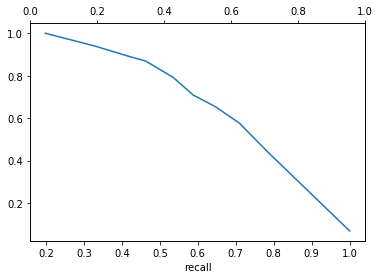

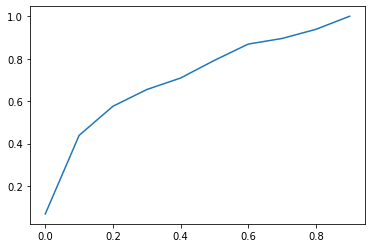

In [14]:
thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
presisions = []
recalls = []

for threshold in thresholds:
    res = count_TPs_FPs_TNs_FNs(all_pred_val, all_gt_val, T = threshold)
    presisions.append(res['precision'])
    recalls.append(res['recall'])

    
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(recalls, presisions)
ax1.set_xlabel('recall')


#ax2.plot([0.9,.8,.7,.6,.5,.4,.3,.2,.1,.0], presisions )

plt.figure()
plt.plot(thresholds, presisions)



    

In [15]:

#FILTER GT VALUES THAT SHOULD BE IGNORED (HAVING PARTIAL SHEEP)
mask = np.array(all_gt_val)!= -1
print(mask)
all_gt_val_filtered = np.array(all_gt_val.copy())[mask]
all_pred_val_filtered = np.array(all_pred_val.copy())[mask]

[ True  True  True ...  True  True  True]


In [16]:
    
res = count_TPs_FPs_TNs_FNs(all_pred_val_filtered, all_gt_val_filtered, T = 0.65)

ground_truth_count = res['TPs'] + res['FNs']
grid_cell_count = len(all_pred_val)
background_count = len(all_pred_val) - ground_truth_count

# If random:
Expected_TP = Expected_FN = ground_truth_count/2
Expected_FP =Expected_TN = background_count/2
Expected_Precision = Expected_TP / (Expected_TP + Expected_FP)
Expected_Recall = Expected_TP / ground_truth_count

print('precision: ', res['precision'] , '\t E(precision): ', Expected_Precision)
print('recall: ', res['recall'] , '\t E(recall): ', Expected_Recall)

print()
print(res)

precision:  0.8928571428571429 	 E(precision):  0.06901041666666667
recall:  0.4716981132075472 	 E(recall):  0.5

{'TPs': 100, 'FPs': 12, 'TNs': 2828, 'FNs': 112, 'precision': 0.8928571428571429, 'recall': 0.4716981132075472}


In [17]:
print(len(all_gt_val), len(all_pred_val))

3072 3072


<class 'numpy.float64'>
Average precision-recall score FILTERED: 0.749


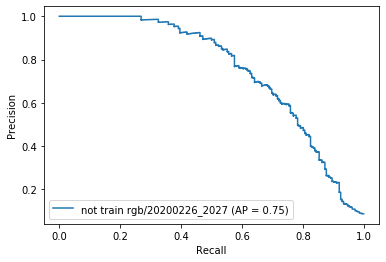

In [18]:
#%conda install -c anaconda scikit-learn
from sklearn.metrics import average_precision_score, precision_recall_curve,  PrecisionRecallDisplay
print(type(all_gt_val[0]))

average_precision_filtered = average_precision_score(np.array(all_gt_val_filtered).astype(int), all_pred_val_filtered)

#average_precision = average_precision_score(np.array(all_gt_val).astype(int), all_pred_val)


#print('Average precision-recall score: {0:0.3f}'.format(
#      average_precision))


print('Average precision-recall score FILTERED: {0:0.3f}'.format(
      average_precision_filtered))
precision, recall, _ = precision_recall_curve(np.array(all_gt_val_filtered).astype(int), all_pred_val_filtered)

#plt.figure()
#plt.plot(recall, precision)

viz = PrecisionRecallDisplay(precision, recall, average_precision_filtered, test_dataset + ' ' + img_type + '/'+time_stamp)
viz.plot()